## Lasso推定量の数値計算方法の確認

In [1]:
## import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import statsmodels.api as sm
from sklearn import datasets
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## seed
np.random.seed(42)


### 1. 凸二次計画にもとづく推定量の計算

> データの生成

- 100 observation, 観測単位のindexは$i \in \{1, ..., 100\}$
- $j\in \{1, 2, \cdots, 30\}$について、それぞれ独立に$X_{ij}\sim N(0, 1)$に従うdataを生成
- noiseとして$\epsilon_i\sim N(0, 1)$
- outcome, $y_i$,は以下の式に基づいて生成

$$
y_i = \sum_{j=1}^{10} \beta_j x_{ij} + \epsilon_i
$$

なお、$\beta_j$についてはコーディングパートを参照

> 凸二次計画にもとづく推定量について

- 目的関数を定式化し、凸最適化ソルバーCVYPYで解かせる方針とする
- 定式化された目的関数の数値計算アルゴリズムはここでは紹介しない

> ここで検証すること

scikit-learn, statsmodels, 凸二次計画にもとづく推定量それぞれにおける損失関数レベルを計算

- scikit-learn: coordicate descent
- statsmodels: cvxoptベースで凸二次計画を解いている（今回は`sqrt_lasso`ベース）
- 自作: 凸最適化ソルバーCVYPYで解かせる


#### 1.1: 損失関数とCVYPY-based estimatorの構築

In [2]:
## 関数定義
def reg_lasso(y, x, penalty):
    k = x.shape[1]
    beta, z = cp.Variable(k), cp.Variable(k)

    obj = cp.Minimize(sum(cp.square(y - x @ beta)) + penalty * sum(z))
    cons = [
            z >= beta,
            z >= -beta
            ]
    
    Problem = cp.Problem(obj, cons)
    Problem.solve(verbose = False)

    return beta.value

## 損失関数の定義
def cal_loss(_y, _X, _param, _penalty):
    predict = _X @ _param
    loss = np.sum((_y - predict)**2) + _penalty * sum(abs(_param))

    return loss

#### 1-2: データ生成

In [3]:
## read data
def generate_data(_beta, _mu_x, _std_x, _mu_eps, _std_eps, _N, _P):
    eps = np.random.normal(_mu_eps, _std_eps, _N)
    X = np.random.normal(_mu_x, _std_x, size=(_N, _P))
    y = np.dot(X, _beta) + eps

    return y, X, eps

## parameters
N = 100 # sample size
P = 30    # rank
mu_eps, std_eps = 0, 1
mu_x, std_x = 0, 1

## simulation data
### making coefficients
#beta_1 = np.random.uniform(0.5, 1.0, 5)
#beta_2 = np.random.uniform(-1.0, -0.5, 5)

beta_1 = np.array([0.68727006, 0.97535715, 0.86599697, 0.79932924, 0.57800932])
beta_2 = np.array([-0.92200274, -0.97095819, -0.56691193, -0.69944249, -0.64596371])
beta_3 = np.zeros(20)
beta = np.concatenate([beta_1, beta_2, beta_3], 0)

### creating dataset
y, X, eps = generate_data(beta, mu_x, std_x, mu_eps, std_eps, N, P)

#### 1-3: Lasso Regression

In [4]:
## estimate
st_lasso_model = sm.OLS(y, X)

## learning
penalty = 10

## sklearn
lasso = Lasso(alpha=penalty/(2*N), fit_intercept = False)
lasso.fit(X, y)

## statsmodel-based regression
st_result = st_lasso_model.fit_regularized(
                                        method='sqrt_lasso',
                                        alpha=penalty,
                                        L1_wt=1.0,
                                        start_params=None,
                                        profile_scale=False,
                                        refit=False
                                        )

## cvxpy-based regression
beta = reg_lasso(y, X, penalty)

In [5]:
### 損失関数の計算
print(cal_loss(y, X, beta, penalty))
print(cal_loss(y, X, st_result.params, penalty))
print(cal_loss(y, X, lasso.coef_, penalty))

137.3641886728875
140.05338256962267
137.36418956509053


### 2: Lasso推定量におけるbias-variance decomposition

In [6]:
def split_train_test(_y, _X, _split_num):
    X_train, X_test = _X[:_split_num], _X[_split_num:]
    y_train, y_test = _y[:_split_num], _y[_split_num:]

    return X_train, X_test, y_train, y_test

def draw_bootstrap_sample(rng, X, y):
    sample_indices = np.arange(X.shape[0])
    bootstrap_indices = rng.choice(sample_indices,
                                   size=sample_indices.shape[0],
                                   replace=True)
    return X[bootstrap_indices], y[bootstrap_indices]

def compute_bias_variance_decomposition(true_estimator,
                         X_train, y_train, X_test, y_test,
                         iter_num=200, random_seed=42,
                         **fit_params):

    rng = np.random.RandomState(random_seed)
    all_pred = np.zeros((iter_num, y_test.size), dtype=np.float64)
    y_true = X_test @ true_estimator

    for i in range(iter_num):
        X_boot, y_boot = draw_bootstrap_sample(rng, X_train, y_train)
        st_lasso_model = sm.OLS(y_boot, X_boot)
        st_result = st_lasso_model.fit_regularized(**fit_params)
        estimate = st_result.params
        y_pred = X_test @ estimate
        all_pred[i] = y_pred

    mse = np.apply_along_axis(
            lambda x:
            ((x - y_test)**2).mean(),
            axis=1,
            arr=all_pred).mean()

    
    main_predictions = np.mean(all_pred, axis=0)
    squared_bias = np.sum((main_predictions - y_true)**2) / y_true.size
    mean_variance = np.sum((main_predictions - all_pred)**2) / all_pred.size

    return mse, squared_bias, mean_variance

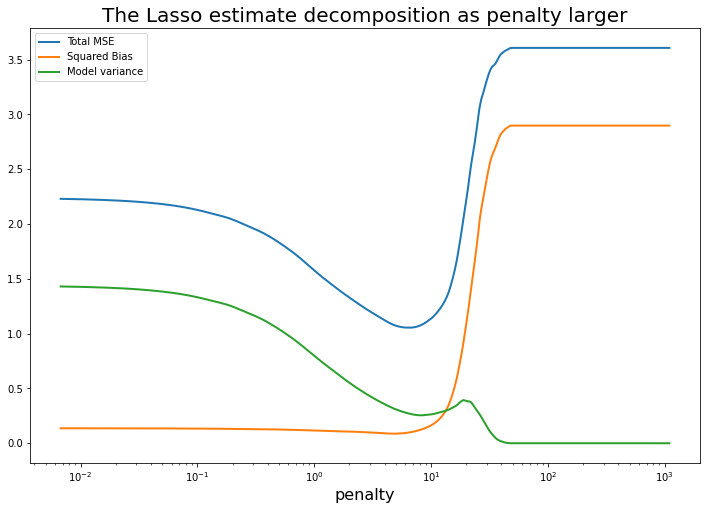

In [7]:
## simulation params
split_num = 70
iter_num = 1000
penalty_range = np.exp(np.linspace(-5, 7, iter_num))
result = np.empty((iter_num, 3))

## generate data
X_train, X_test, y_train, y_test = split_train_test(y, X, split_num)


for array_index, _penalty in enumerate(penalty_range):
    result[array_index,:] = compute_bias_variance_decomposition(true_estimator=beta,
                                                                X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                                                                iter_num=20, random_seed=42,
                                                                alpha = _penalty, method='sqrt_lasso', L1_wt=1.0,
                                                                start_params=None, profile_scale=False, refit=False)

## plot
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(penalty_range,result,label = ['Total MSE', 'Squared Bias', 'Model variance'],lw=2)
ax.set_title('The Lasso estimate decomposition as penalty larger', fontsize=20)
ax.set_xlabel('penalty', fontsize=16)
ax.set_xscale('log')
ax.legend();